In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

Write a code that implements a basic form of the block-based hybrid video coder for coding
a P-frame using a fixed block size of 8x8. For simplicity, consider intra-prediction using only
the first 3 intra prediction modes shown below over 8x8 blocks, and inter-prediction using
integer accuracy EBMA, with a specified search range, e.g. +/-24. You program should do
the following for each block: 
- i) find the best intra-prediction mode and the corresponding
error block and the mean squared error (MSE) of the prediction; 
- ii) find the best MV for inter-prediction and the corresponding
error block and its MSE; 
- iii) Choose the prediction block whose prediction error has the
smaller MSE; 
- iv) Perform 8x8 DCT on the prediction error block of the chosen mode; 
- v) Quantize all the DCT coefficients with the same quantization step-size (QS) q; Note that you should assume the prediction error has zero mean and use a quantizer that is symmetric with respect to 0;  
- vi) Count how many non-zero coefficients you have after quantization, 
- vii) Reconstruct the error block by performing inverse DCT on quantized DCT coefficients; 
- viii) Reconstruct the original block by adding the reconstructed error block into the best prediction block. 
![img](img.png)
Instead of developing a real entropy coder, we will use the total number of non-zero DCT coefficients as an
estimate of the bit rate and ignore the bits needed to code the side information (mode info,
motion vector, etc.). Your program should determine the PSNR of the reconstructed image
(compared to the original image) and the total number of non-zero quantized DCT
coefficients K, for a given quantization step-size q.

You should repeat the above operations(iv,v,vi,vii,viii) for a set of q=1,2,4,8, 16, and determine the PSNR and K for each q, and draw the resulting PSNR vs. K curve, as a substitute for the PSNR vs. rate curve.

You can download the dataset from the following link:
https://www.dropbox.com/sh/dslrefteks5onvx/AADk4XNr7pZh23BamcqBrEzqa?dl=0

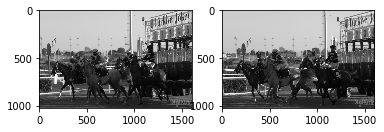

In [7]:
################################################ TODO ###############################################
# Read in two frames that are several frames apart.
# For example, frame100 and frame110
# Convert them to gray scale, then plot
frame170 = './data/IMG_0170.png'
img1 = cv2.imread(frame170,0).astype(float)
img1 = cv2.resize(img1,(1600,1024))

frame180 = './data/IMG_0180.png'
img2 = cv2.imread(frame180,0).astype(float)
img2 = cv2.resize(img2,(1600,1024))

fig, ax = plt.subplots(1,2)
ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray')
plt.show()

In [12]:
################################################ TODO ###############################################
# Define msefun() which calculates the mse of the error block
def msefun(error):
    '''
    strange
    why defining this stand alone?
    '''
    mse = np.mean((error)**2)
    return mse

In [13]:
################################################ TODO ###############################################
# Define EBMA() which takes as input the template(target block), image, template location(x0, y0) and search range
# Return the matching block and the motion vector
def EBMA(template,img,x0,y0,range_x,range_y):
    # get the number of rows and columns of the image
    rows, cols = img.shape
    # get the number of rows and columns of the template
    b_rows, b_cols = template.shape
    # initialize maximum error, motion vector and matchblock
    max_mse = 1e8
    xm = 0
    ym = 0
    matchblock = np.zeros(template.shape)
    # loop over the searching range to find the matchblock with the smallest error.
    for i in range(max(1,x0-range_x),min(rows-b_rows,x0+range_x)):
        for j in range(max(1,y0-range_y),min(cols-b_cols,y0+range_y)):
            candidate = img[i:i+b_rows, j:j+b_cols]
            error = template = candidate
            mse = msefun(error)
            if mse < max_mse:
                # update motion vector, matchblock and max_error if the error of the new block is smaller
                xm = i
                ym = j
                matchblock = candidate
                max_mse = mse
    return xm, ym, matchblock

In [14]:
################################################ TODO ###############################################
# define quantization function to quantize the dct coefficients
# recall the quantization function: Q(f)=floor( (f-mean+Q/2)/Q) *Q+mean
# Suppose the mean of the dct coefficients of the error image is 0
def quant(dct_coef, q):
    # Why we want the shape of that again?
    # rows, cols = dct_coef.shape 
    
    dctimg_quant = np.floor((dct_coef+q/2)/q)*q
    return dctimg_quant

In [39]:
################################################ TODO ###############################################
# Loop through all blocks and find the blocks with minimum error variance. 
# define searching range for EBMA
range_x = 24
range_y = 24
# get the rows and columns of the images.
rows, cols = img2.shape
# define the block size
N = 8
# initialize the predicted block, error block, variance array
pred_block = np.zeros((N,N))
err_block = np.zeros((N,N))
min_pred_block = np.zeros((N,N))
min_err_block = np.zeros((N,N))

# initialize the predicted quantized block 
pred_quant = np.zeros(img2.shape)
pred_image = np.zeros(img2.shape)
err_image = np.zeros(img2.shape)

for i in tqdm(range(int(rows/N))):
    for j in range(int(cols/N)):
        #get the current block
        patch = img2[i*N:i*N+N, j*N:j*N+N] # patch is the ground truth
        min_MSE=N*N*255^2 

        # mode 0
        if i == 0:
            pred_block = img2[i*N-N:, j*N:j*N+N]
        else:
            pred_block = img2[i*N-N:i*N, j*N:j*N+N]
        
        # get the error block between the predicted block and the current block
        err_block = pred_block - patch
        # calculate the mse of the error block
        mse = msefun(err_block)
        # updata the predicted block and error block if the mse is smaller
        if mse < min_MSE: 
            min_pred_block = pred_block
            min_err_block = err_block
            min_MSE = mse
            
        #mode 1
        
        if j == 0:
            pred_block = img2[i*N:i*N+N, j*N-N:]
        else:
            pred_block = img2[i*N:i*N+N, j*N-N:j*N]
            
        err_block = pred_block - patch
        mse = msefun(err_block)
        if mse < min_MSE: 
            min_pred_block = pred_block
            min_err_block = err_block
            min_MSE = mse
            
        #mode 2
        
        if i == 0 and j != 0:
            pred_block = (img1[i*N-N:, j*N:j*N+N] + img2[i*N:i*N+N, j*N-N:j*N])/2
        elif i == 0 and j == 0:
            pred_block = (img1[i*N-N:, j*N:j*N+N] + img2[i*N:i*N+N, j*N-N:])/2
        elif i != 0 and j == 0:
            pred_block = (img1[i*N-N:i*N, j*N:j*N+N] + img2[i*N:i*N+N, j*N-N:])/2
        else:
            pred_block = (img1[i*N-N:i*N, j*N:j*N+N] + img2[i*N:i*N+N, j*N-N:j*N])/2
            
        err_block = pred_block - patch
        mse = msefun(err_block)
        if mse < min_MSE: 
            min_pred_block = pred_block
            min_err_block = err_block
            min_MSE = mse

        #inter-prediction
        #perform EBMA to the current block in img1
        xm,ym,pred_block = EBMA(patch, img1, i*N, j*N, range_x, range_y)
        err_block = pred_block - patch
        mse = msefun(err_block)
        if mse < min_MSE: 
            min_pred_block = pred_block
            min_err_block = err_block
            min_MSE = mse
        
        pred_image [i*N:(i+1)*N,j*N:(j+1)*N] = min_pred_block
        err_image [i*N:(i+1)*N,j*N:(j+1)*N] = err_block
        # Perform DCT to the error block with the minimum error variance
        dct_block = cv2.dct(min_err_block)
        # Quantize it with Q=2
        dct_block_q = quant(dct_block, q=2)
        # Count the number of nonzeros in the quantized coefficients
        non_zero = np.count_nonzero(dct_block_q)
        # Perform IDCT to the quantized coefficients
        rec_err_block = cv2.idct(dct_block_q)
        # Reconstruct the block by adding the predicted block to the reconstructed error block
        
        pred_quant[i*N:(i+1)*N,j*N:(j+1)*N] = min_pred_block - rec_err_block


 52%|██████████████████████████████████████████▍                                      | 67/128 [08:26<07:13,  7.11s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [15:59<00:00,  5.73s/it]

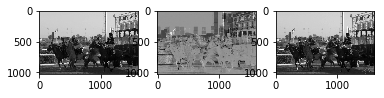

In [40]:
################################################ TODO ###############################################
# plot the predicted image, error image and the reconstructed image
fig, ax = plt.subplots(1,3)
ax[0].imshow(pred_image, cmap='gray')
ax[1].imshow(err_image, cmap='gray')
ax[2].imshow(pred_quant, cmap='gray')
plt.show()

In [44]:
################################################ TODO ###############################################
# QUANTIZE WITH DIFFERENT STEP SIZE: 1,2,4,8,...
qarray = np.logspace(0, 4, base=2)
pre_q = np.zeros(img2.shape)
dct_block_q = np.zeros(img2.shape)
rec_err_block = np.zeros(img2.shape)
non_zeros = np.zeros(qarray.shape)
PSNR = np.zeros(qarray.shape)

for q, qvalue in enumerate(qarray):
    for i in range(int(rows/N)):
        for j in range(int(cols/N)):
            # perform DCT to the current error patch
            dct_block = cv2.dct (err_image[i*N:(i+1)*N,j*N:(j+1)*N])
            # quantize the coefficients
            dct_block_q[i*N:(i+1)*N,j*N:(j+1)*N] = quant(dct_block, qvalue)
            # IDCT 
            rec_err_block[i*N:(i+1)*N,j*N:(j+1)*N] = cv2.idct(dct_block_q[i*N:(i+1)*N,j*N:(j+1)*N])
            # reconstruct the block
            pre_q[i*N:(i+1)*N,j*N:(j+1)*N] = pred_image[i*N:(i+1)*N,j*N:(j+1)*N] - rec_err_block[i*N:(i+1)*N,j*N:(j+1)*N]
    # calculate the number of non-zeros
    non_zeros[q] = np.count_nonzero(rec_err_block)
    # calculate PSNR
    
    # mse = np.mean((reconstructed_image_quant-image)**2)
    # psnr = 10*np.log10(256**2/mse)
    mse = msefun(img2 - pre_q)
    PSNR[q] = 10*np.log10(256**2/mse)

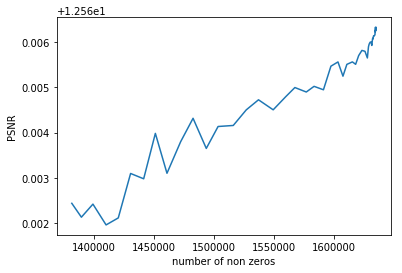

In [43]:
#plot the curve of # of nonzeros vs PSNR
plt.plot(non_zeros, PSNR)
plt.xlabel('number of non zeros')
plt.ylabel('PSNR')
plt.show()